In [1]:
%run setup_PS_data_multi.ipynb  # This notebook loads all data & some packages
import pandas as pd
import math, cmath
from tqdm import tqdm
import scipy.stats
import pop_off_functions as pof
import importlib
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

Now loading mouse RL070, run 22
Now loading mouse RL070, run 23
Now loading mouse RL070, run 24
Now loading mouse RL070, run 27
Now loading mouse RL070, run 28
microcontroller trial starts occur on average -70.14 ms from galvo trial starts
1 / 625 cells filtered
photo stim occurences: {0: 127, 1: 140, 2: 119}
Occurence table:
[[123.   4.]
 [119.  21.]
 [ 80.  39.]]
375 / 375 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 28
Now loading mouse RL070, run 29
microcontroller trial starts occur on average nan ms from galvo trial starts
0 / 718 cells filtered
photo stim occurences: {0: 96, 1: 93, 2: 90}
Occurence table:
[[78. 18.]
 [46. 47.]
 [35. 55.]]
263 / 263 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 29
Now loading mouse J047, run 7
Now loading mouse J048, run 15
Now loading mouse J048, run 16
Now loading mouse J048, run 18
Now loading mouse J04

In [19]:
## To reload the pof module (e.g. after changing a function), run:

importlib.reload(pof)

<module 'pop_off_functions' from '/home/tplas/repos/pop-off/photo-stim/pop_off_functions.py'>

# Intro


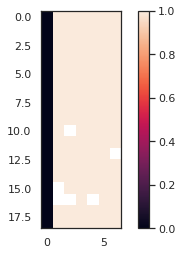

In [3]:
plt.imshow(pof.beh_metric(sessions=sessions, metric='sensitivity'))
plt.colorbar()

In [4]:
## Shuffle data:
bool_shuffle_trials = False
bool_shuffle_s1s2 = False

for ii in range(len(sessions)):
    if bool_shuffle_trials:
        sessions[ii].shuffle_trial_labels()
    if bool_shuffle_s1s2:
        sessions[ii].shuffle_s1s2_labels()

## Single time point decoder example:

Mouse J048, Starting loop 1/1


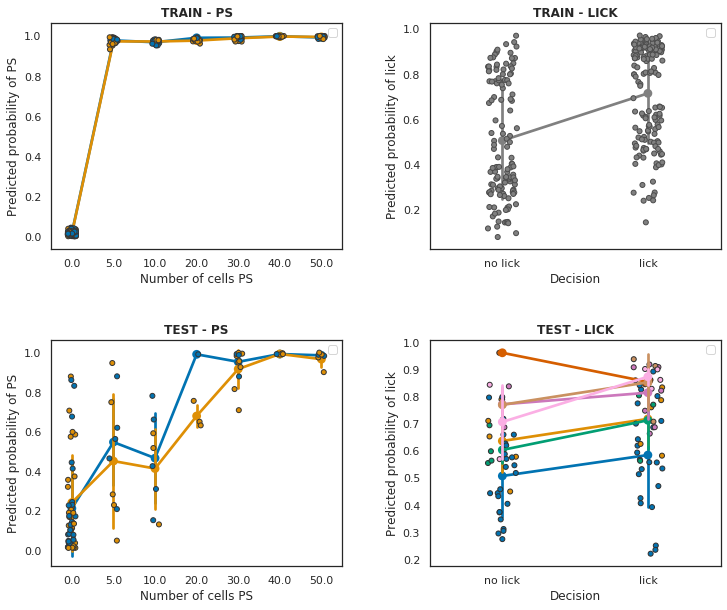

In [6]:
time_frame = 1.2
n_splits = 4
ss_dict = {0: sessions[2]}

df_prediction_train, df_prediction_test, tmp = pof.train_test_all_sessions(sessions=ss_dict, verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]), return_decoder_weights=True,
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='s1',
                                         C_value=50, train_projected=True, proj_dir='same')

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
## NB: To not plot with hue, set hh=None
# for mouse in df_prediction_train.keys():
for mouse in [ss_dict[0].mouse]:
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        pof.plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train_proj', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([])

        plt.subplot(223)
        pof.plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test_proj', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([])
#         print(f'Accuracy PS: {pof.class_av_mean_accuracy(binary_truth=(df_prediction_test[mouse]["true_stim_test"] > 0).astype("int"), estimate=df_prediction_test[mouse]["pred_stim_test_proj"])[0]}')
        
    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        pof.plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train_proj', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick')

        plt.subplot(224)
        pof.plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test_proj', hh='true_stim_test', xticklabels=['no lick', 'lick'], type_scatter='strip')
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([])
#         print(f'Accuracy lick: {pof.class_av_mean_accuracy(binary_truth=df_prediction_test[mouse]["true_dec_test"], estimate=df_prediction_test[mouse]["pred_dec_test_proj"])[0]}')
# plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
# #              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
#              f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

In [7]:
## Inspect influence autorewards:
# mouse = 'J048'
# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 1,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 0,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][df_prediction_test[mouse]['true_stim_test'] > 0 ]['pred_dec_test'].mean())

## Train dynamic decoders:

In [8]:
## Create list with standard colors:
color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break  # after 8 it repeats (for ever)

## Integrate different imaging frequencies to create an array of mutual (shared) time points:
freqs = np.unique([ss.frequency for _, ss in sessions.items()])
tp_dict = {}
for ff in freqs:
    for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
        if ss.frequency == ff:
            tp_dict[ff] = ss.filter_ps_time
if len(freqs) == 2:  # for hard-coded bit next up
    tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
elif len(freqs) == 1:
    tp_dict['mutual'] = tp_dict[freqs[0]]

In [9]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
     angle_dec, decoder_weights) = pof.compute_accuracy_time_array(sessions=sessions, time_array=tp_dict['mutual'],
                                              projected_data=False, reg_type='none',
                                              average_fun=pof.class_av_mean_accuracy)

46it [04:22,  5.70s/it]


## Check single neurons

546

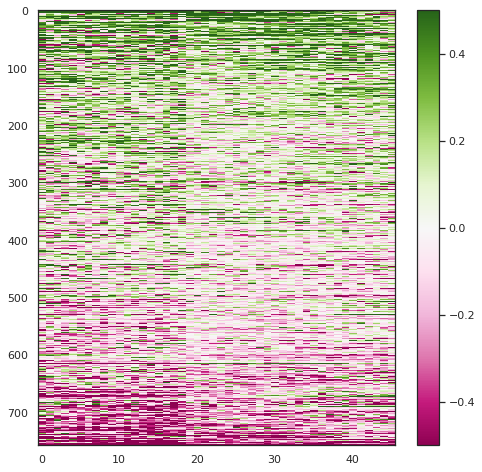

In [11]:
dw = decoder_weights['s1_stim']['J048_R29']
dw_as = np.argsort(np.sum(dw, 1))[::-1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(dw[dw_as, :], aspect='auto', cmap='PiYG', vmin=-0.5, vmax=0.5)
plt.colorbar()
# plt.plot(np.mean(np.abs(dw[dw_as[900:], :]), 0))

dw_as[300]

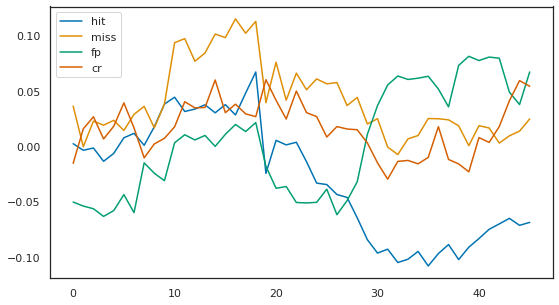

In [12]:
s2_inds = np.where(sessions[2].s1_bool)[0]
plt.rcParams['figure.figsize'] = (9, 5)
neuron_data = sessions[2].behaviour_trials[s2_inds[dw_as[6]], :,:][:, sessions[2].filter_ps_array]
for tt in ['hit', 'miss', 'fp', 'cr']:
    plt.plot(np.mean(neuron_data[sessions[2].outcome == tt, :], 0), label=tt)
# for tt in [0, 1]:
#     plt.plot(np.mean(neuron_data[sessions[2].decision == tt, :], 0), label=tt)

plt.legend()

## Create PS decoding summary plot

In [13]:
## Which time points to include in violin plots:
tp_list = [1.0, 3.8]  # in seconds

region_list = ['s1', 's2']
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:  # retrain (deterministic) decoders for these time points, and save detailed info
        _, dict_df_test[reg][tp] = pof.train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
                                     trial_times_use=np.array([tp]), return_decoder_weights=False,
                                     hitmiss_only=False,# list_test=['dec', 'stim'],
                                     include_autoreward=True, neurons_selection=reg,
                                     C_value=0.02, train_projected=True)

## turn into df that can be used for violin plots efficiently,
## normalised so that each animals is equally important in averaging
violin_df_test = pof.make_violin_df_custom(input_dict_df=dict_df_test, 
                                           flat_normalise_ntrials=True, verbose=1) 

Number of trials for mouse J048: 730, multiplications: 13.7
Number of trials for mouse J063: 217, multiplications: 46.08
Number of trials for mouse J064: 360, multiplications: 27.78
Number of trials for mouse J065: 259, multiplications: 38.61
Number of trials for mouse RL048: 832, multiplications: 12.02
Number of trials for mouse RL070: 437, multiplications: 22.88
Corrected number of trials for mouse J048: 20440
Corrected number of trials for mouse J063: 19964
Corrected number of trials for mouse J064: 20160
Corrected number of trials for mouse J065: 20202
Corrected number of trials for mouse RL048: 19968
Corrected number of trials for mouse RL070: 20102


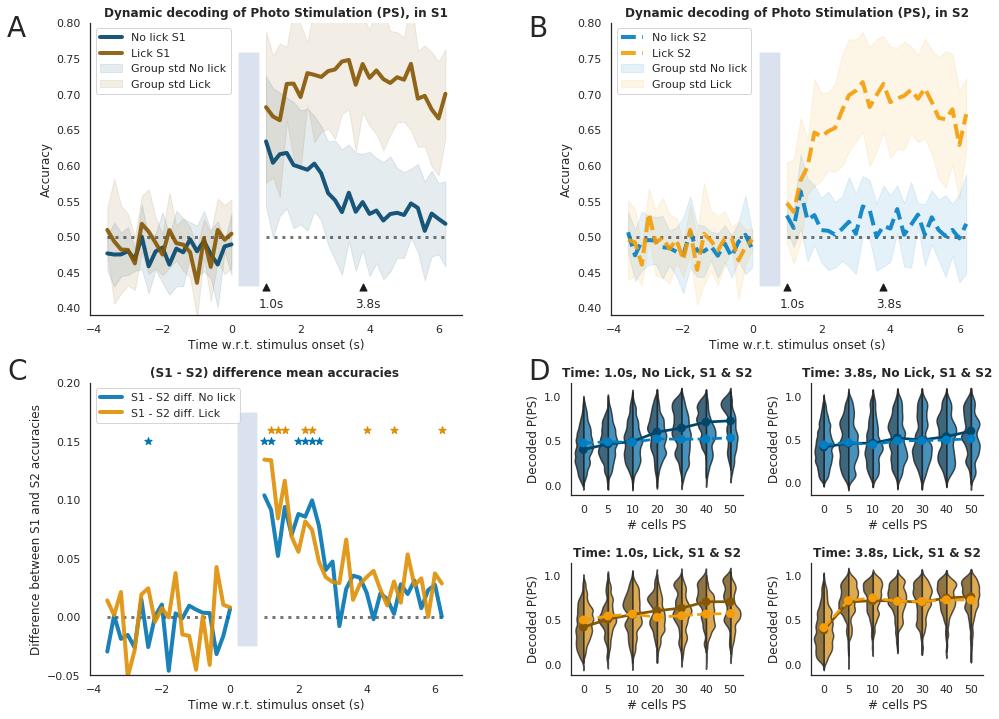

In [22]:
## PS decoding figure
plt.rcParams['figure.figsize'] = (16, 12)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
p_val_thresh = 0.05  # P val for wilcoxon sr test.
new_time = tp_dict['mutual']
label_split = {0: 'No lick', 1: 'Lick'}
linest = {'s1': '-', 's2': '--'}
colors_plot = {'s1': {lick: 0.6 * np.array(color_dict_stand[lick]) for lick in [0, 1]},
               's2': {lick: 1.1 * np.array(color_dict_stand[lick]) for lick in [0, 1]}}
tp_violin = list(violin_df_test.keys())
## Average S1 & S2
# plot_interrupted_trace(ax=ax_acc_ps2,  time_array=new_time, plot_array=ps_acc, plot_indiv=False,
#                        llabel='Average', ccolor=color_dict_stand[7])  # average between regions

## S1 figure:
ax_acc_ps1 = plt.subplot(4, 2, (1, 3))
pof.plot_interrupted_trace_simple(ax=ax_acc_ps1, time_array=new_time, plot_array=np.zeros_like(new_time) + 0.5, 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pof.plot_interrupted_trace(ax=ax_acc_ps1, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=colors_plot['s1'][i_lick], plot_indiv=False, plot_laser=i_lick, 
                           plot_errorbar=False, plot_std_area=True, region_list=['s1'])
for tp in tp_violin:
    ax_acc_ps1.scatter([tp], [.43], marker='^', s=50, color='k')
    ax_acc_ps1.text(s=f'{tp}s', x=tp - 0.22, y=0.4)
ax_acc_ps1.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc_ps1.set_ylabel('Accuracy')
ax_acc_ps1.legend(loc='upper left'); ax_acc_ps1.set_title('Dynamic decoding of Photo Stimulation (PS), in S1', weight='bold')
ax_acc_ps1.set_ylim([0.39, 0.8])

## S2 figure:
ax_acc_ps2 = plt.subplot(4, 2, (2, 4))
pof.plot_interrupted_trace_simple(ax=ax_acc_ps2, time_array=new_time, plot_array=np.zeros_like(new_time) + 0.5, 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pof.plot_interrupted_trace(ax=ax_acc_ps2, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=colors_plot['s2'][i_lick], plot_indiv=False, plot_laser=i_lick, 
                           plot_errorbar=False, plot_std_area=True, region_list=['s2'])
for tp in tp_violin:
    ax_acc_ps2.scatter([tp], [.43], marker='^', s=50, color='k')
    ax_acc_ps2.text(s=f'{tp}s', x=tp - 0.22, y=0.4)
ax_acc_ps2.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc_ps2.set_ylabel('Accuracy')
ax_acc_ps2.legend(loc='upper left'); ax_acc_ps2.set_title('Dynamic decoding of Photo Stimulation (PS), in S2', weight='bold')
ax_acc_ps2.set_ylim([0.39, 0.8])

## S1/S2 difference fig:
ax_diff = plt.subplot(4, 2, ((5, 7)))
pof.plot_interrupted_trace_simple(ax=ax_diff, time_array=new_time, plot_array=np.zeros_like(new_time), 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pof.plot_interrupted_trace(ax=ax_diff, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=color_dict_stand[i_lick], plot_indiv=False, plot_laser=i_lick, 
                           plot_errorbar=False, plot_std_area=False, region_list=['s1', 's2'], plot_diff_s1s2=True)
    p_vals_wsr = pof.wilcoxon_test(dict_part)
    inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
    ax_diff.scatter(new_time[inds_sign], np.zeros_like(inds_sign) + .15 + (i_lick * 0.01), marker='*', s=60, color=color_dict_stand[i_lick])
ax_diff.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_diff.set_ylabel('Difference between S1 and S2 accuracies')
ax_diff.legend(loc='upper left'); ax_diff.set_title('(S1 - S2) difference mean accuracies ', weight='bold')
ax_diff.set_ylim([-0.05, 0.2])

## Violin plots
lick_title = {0: 'No Lick', 1: 'Lick'}
for i_tp, tp in enumerate(tp_violin):
    for lick in [0, 1]:
        plt.subplot(4, 4, 11 + i_tp + 4 * lick)
        plot_df = violin_df_test[tp]
        viol = sns.violinplot(data=plot_df[plot_df['true_dec_test'] == lick], x='true_stim_test', y='pred_stim_test',
                       palette=[0.6 * np.array(color_dict_stand[lick]), 1.1 * np.array(color_dict_stand[lick])],
                       hue='region', split=True, inner=None)
        plt.setp(viol.collections, alpha=0.8)
        sns.pointplot(data=plot_df[plot_df['true_dec_test'] == lick], x='true_stim_test', y='pred_stim_test',
                       palette=[0.6 * np.array(color_dict_stand[lick]), 1.1 * np.array(color_dict_stand[lick])],
                       hue='region', label=None, linestyles=[linest['s1'], linest['s2']])
        plt.title(f'Time: {tp}s, {lick_title[lick]}, S1 & S2', weight='bold')
        viol.legend_.remove();
        plt.xlabel('# cells PS'); plt.ylabel('Decoded P(PS)')
        viol.set_xticklabels([0, 5, 10, 20, 30, 40, 50])
## Labels:
ax_acc_ps1.text(s='A', x=-6.5, y=0.78, fontdict={'weight': 'normal', 'fontsize': 28})
ax_acc_ps2.text(s='B', x=-6.5, y=0.78, fontdict={'weight': 'normal', 'fontsize': 28})
ax_acc_ps1.text(s='C', x=-6.5, y=0.30, fontdict={'weight': 'normal', 'fontsize': 28})
ax_acc_ps2.text(s='D', x=-6.5, y=0.30, fontdict={'weight': 'normal', 'fontsize': 28})
sns.despine()
# plt.savefig('figures/decoding_ps.pdf', bbox_inches='tight')

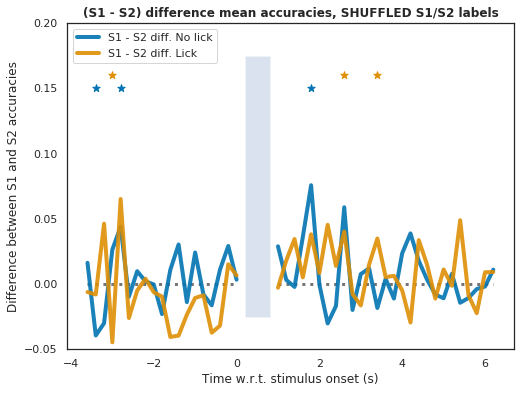

In [20]:
## Same plot as previous figure panel C; to only show difference in case of shuffled labels
plt.rcParams['figure.figsize'] =(8, 6)
ax_diff = plt.subplot(111)
pof.plot_interrupted_trace_simple(ax=ax_diff, time_array=new_time, plot_array=np.zeros_like(new_time), 
                              ccolor='k', aalpha=0.6, llinewidth=3, linest=':')
for i_lick, dict_part in ps_acc_split.items():  # PS accuracy split per lick /no lick trials
    pof.plot_interrupted_trace(ax=ax_diff, time_array=new_time, plot_array=dict_part, llabel=label_split[i_lick], 
                           ccolor=color_dict_stand[i_lick], plot_indiv=False, plot_laser=i_lick, 
                           plot_errorbar=False, plot_std_area=False, region_list=['s1', 's2'], plot_diff_s1s2=True)
    p_vals_wsr = pof.wilcoxon_test(dict_part)
    inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
    ax_diff.scatter(new_time[inds_sign], np.zeros_like(inds_sign) + .15 + (i_lick * 0.01), marker='*', s=60, color=color_dict_stand[i_lick])
ax_diff.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_diff.set_ylabel('Difference between S1 and S2 accuracies')
ax_diff.legend(loc='upper left'); ax_diff.set_title('(S1 - S2) difference mean accuracies, SHUFFLED S1/S2 labels', weight='bold')
ax_diff.set_ylim([-0.05, 0.2])
# plt.savefig('figures/shuffled_s1s2_ps_decoding_difference.pdf')

## Lick decoding

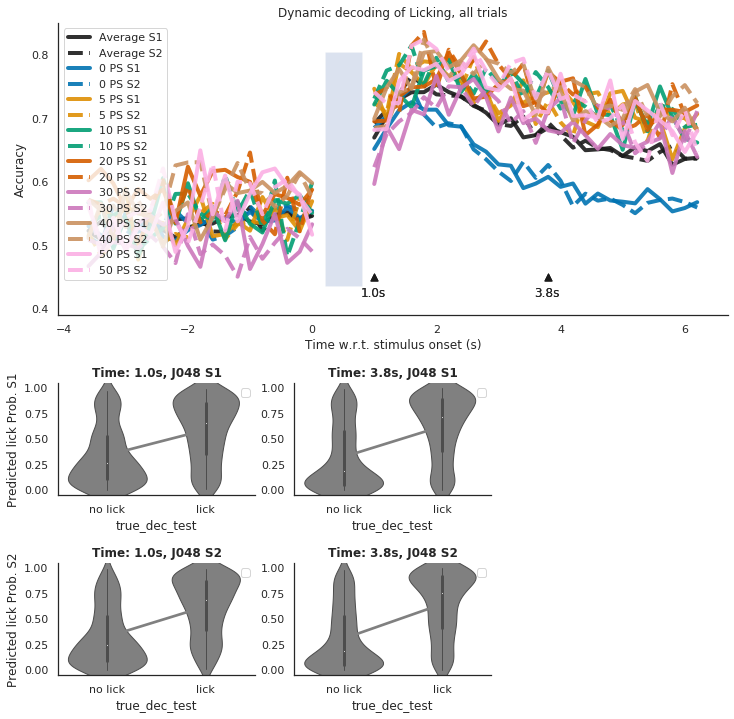

In [23]:
## Lick decoding figure
plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
pof.plot_interrupted_trace(ax=ax_acc,  time_array=new_time,plot_array=lick_acc, #individual_mouse_list=['J065_s1', 'J065_s2'],
                       llabel='Average', ccolor='k', plot_std_area=False, plot_indiv=False)

plot_dict_split = lick_acc_split
label_split = {x: f'{x} PS' for x in lick_acc_split.keys()}
for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
    dict_part = plot_dict_split[key]
    pof.plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
                           ccolor=color_dict_stand[iplot], plot_indiv=False, plot_laser=False)

ax_acc.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Licking, all trials');
ax_acc.set_ylim([0.39, 0.85])

# p_vals_wsr = pof.wilcoxon_test(lick_acc)
# inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
# ax_acc.scatter(new_time[inds_sign], np.zeros_like(inds_sign)  + .82, marker='*', s=60, color='k')

mouse = 'J048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        pof.plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_dec_test', yy='pred_dec_test', hh=None,
                      xticklabels=['no lick', 'lick'], type_scatter='violin', ccolor='grey')  # set hh=None or hh='dec_test'
        plt.title(f'Time: {tp}s, {mouse} {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([tp], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{tp}s', x=tp - 0.22, y=0.42)
        if i_tp == 0:
             plt.ylabel(f'Predicted lick Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()
# plt.savefig('figures/decoding_licks.png', dpi=300, bbox_inches='tight')

## Difference PS & Lick decoders:

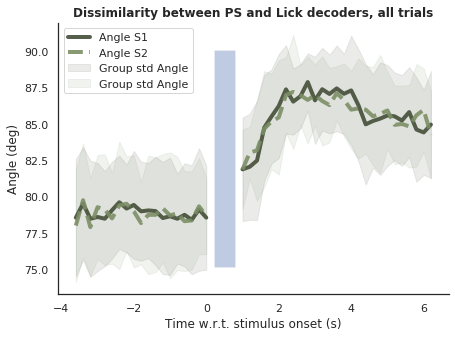

In [24]:
## Angle change figure
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)

mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
region_list=['s1', 's2']
freq = 5
new_time = tp_dict['mutual']
for reg in region_list:
    ax_acc, mean_angle_traces = pof.plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=angle_dec, llabel='Angle',
                                           plot_errorbar=False, plot_indiv=False, plot_std_area=True, region_list=[reg],
                                                      ccolor=0.5 * (colors_plot[reg][0] + colors_plot[reg][1]))
# p_vals_wsr = pof.wilcoxon_test(angle_dec)
# inds_sign = np.where(p_vals_wsr < p_val_thresh)[0]
# ax_acc.scatter(new_time[inds_sign], np.zeros_like(inds_sign) + 93, marker='*', s=60, color='grey')
ax_acc.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc.set_ylabel('Angle (deg)')
ax_acc.legend(); ax_acc.set_title('Dissimilarity between PS and Lick decoders, all trials', weight='bold')
sns.despine()
# plt.savefig('figures/angle_decoders.png', dpi=300, bbox_inches='tight')
# plt.savefig('figures/angle_decoders.pdf', bbox_inches='tight')

# Supplemental figs

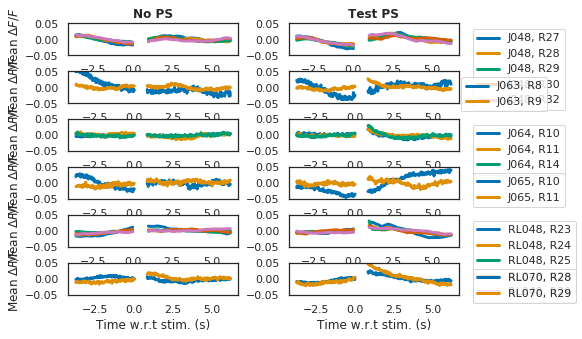

In [25]:
## Averages of all sessions:
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.rcParams['figure.figsize'] = (8, 12)
title_ps = {0: 'No PS', 1: 'Test PS', 2: '150 PS', 3: 'Run legend:'}
# mouse = mouse_list[5]
# mouse_list = mouse_list[:2]
av_axes = {}
i_ax = 0
range_ps = 2
color_index = {m: 0 for m in mouse_list}
legend_tuple = []
for i_m, mouse in enumerate(mouse_list):
    temp_session_list = [k for k, ss in sessions.items() if ss.mouse == mouse]
    for i_s in temp_session_list:
        ss = sessions[i_s]
        for i_ps in range(range_ps):
            av_axes[i_ax] = plt.subplot(len(mouse_list), range_ps, 1 + i_ps + range_ps * i_m)
            if i_ps <= 2:
                pof.plot_interrupted_trace_simple(ax=av_axes[i_ax], time_array=ss.filter_ps_time,
                                              plot_array=np.mean(ss.behaviour_trials[:, ss.photostim == i_ps, :][:, :, ss.filter_ps_array], (0, 1)), 
                                              llabel=f'{mouse}, R{ss.run_number}', ccolor=color_dict_stand[color_index[mouse]], zero_mean=True)
            if i_ps <= 1:
                av_axes[i_ax].set_ylim([-0.05, 0.05])
            if i_m == 0:
                av_axes[i_ax].set_title(title_ps[i_ps], weight='bold')
            if i_m == len(mouse_list) - 1:
                av_axes[i_ax].set_xlabel('Time w.r.t stim. (s)')
            if i_ps == 0:
                av_axes[i_ax].set_ylabel('Mean ' + r'$\Delta F / F$')
            if i_ps == range_ps - 1 and i_s == temp_session_list[-1]:
                if mouse == 'J063':
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.55, 1))  # no clue why this needed
                else:
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.05, 1))
                legend_tuple.append(leg)
            i_ax += 1
        color_index[mouse] += 1
legend_tuple = tuple(legend_tuple)
# plt.savefig('figures/average_all_sessions.pdf', bbox_extra_artists=legend_tuple, bbox_inches='tight')


In [262]:
## Plot overlay of means all frames & filtered frames. => manually assessed that the current frame
## filter is the minimal to filter the artefact in all sessions. But for all 5Hz but 1, it could be shorter.
## For 30Hz it can be shorter as well, probably some nice info directly post stim.

# ss = sessions[kk] 
# print(ss)
# plt.rcParams['figure.figsize'] = (9, 5)
# plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim == 1, :], (0, 1)), '.-')
# plt.plot(ss.filter_ps_array, np.mean(ss.behaviour_trials[:, ss.photostim == 1, :][:, :, ss.filter_ps_array], (0, 1)), '.-')
# kk += 1

## Cross validate regularization value

Idea:
  - It depends on number of neurons. So either scale with n_neurons, but I'm not sure what scaling (e.g. linear) this is.. So instead we'll optimise per session. S1/S2 are about 50/50 so we'll ignore this (also because their perfomance varies)
  - Per session; evaluate 3 seconds post stim at 5Hz. Find the maximum test decoding accuracy (for both decoders). we'll take the corresponding C value.
  - Save in some file because this takes some time to run

In [128]:
df_prediction_train, df_prediction_test = pof.train_test_all_sessions(sessions={0: sessions[2]}, trial_times_use=np.array([1.6]), 
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=True, C_value=0.002,
                                                          train_projected=False,
                                                          neurons_selection='s1')

In [341]:
## Integrate different imaging frequencies:
assert 'mutual' in tp_dict.keys()
tp_dict['cv_reg'] = tp_dict['mutual'][np.logical_and(tp_dict['mutual'] <= 3, tp_dict['mutual'] > 0)]  # Use all time points < 3 post stim
c_value_array = np.array([50, 20, 5, 2, 0.5, 0.2, 0.05, 0.02, 0.005, 0.002])  # list of C values, where 1/C is reg strength
max_acc_scores = {}
for key, ss in sessions.items():
    print(ss)
    ## First without reg:
    max_dec_values = np.zeros((len(c_value_array) + 1, 2))
    (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
             angle_dec) = pof.compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                      projected_data=False, reg_type='none', average_fun=pof.class_av_mean_accuracy)
    max_lick_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
    max_ps_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
    max_dec_values[0, :] = max_lick_dec.copy(), max_ps_dec.copy()  
    ## Then with varying reg strengths:
    for i_c, c_value in enumerate(c_value_array):
        ## Compute results
        (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
             angle_dec) = pof.compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                      projected_data=False, regularizer=c_value,
                                                      average_fun=pof.class_av_mean_accuracy)
        max_lick_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
        max_ps_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
        max_dec_values[i_c + 1, :] = max_lick_dec.copy(), max_ps_dec.copy()
    ## Save:
    max_acc_scores[key] = max_dec_values.copy()
    

0it [00:00, ?it/s]

Mouse RL070, run 28


11it [00:04,  2.52it/s]
11it [00:06,  1.63it/s]
11it [00:06,  1.63it/s]
11it [00:06,  1.66it/s]
11it [00:06,  1.72it/s]
11it [00:05,  1.87it/s]
11it [00:05,  2.04it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.56it/s]
11it [00:03,  2.81it/s]
11it [00:03,  2.89it/s]
0it [00:00, ?it/s]

Mouse RL070, run 29


11it [00:03,  3.01it/s]
11it [00:05,  2.01it/s]
11it [00:05,  2.03it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.02it/s]
11it [00:04,  2.20it/s]
11it [00:04,  2.34it/s]
11it [00:03,  2.76it/s]
11it [00:03,  2.86it/s]
11it [00:03,  3.22it/s]
11it [00:03,  3.29it/s]
0it [00:00, ?it/s]

Mouse J048, run 27


11it [00:02,  4.10it/s]
11it [00:03,  2.90it/s]
11it [00:04,  2.74it/s]
11it [00:03,  2.77it/s]
11it [00:03,  2.77it/s]
11it [00:03,  2.84it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.24it/s]
11it [00:03,  3.58it/s]
11it [00:02,  4.07it/s]
11it [00:02,  4.25it/s]
0it [00:00, ?it/s]

Mouse J048, run 28


11it [00:03,  3.66it/s]
11it [00:04,  2.58it/s]
11it [00:04,  2.57it/s]
11it [00:04,  2.55it/s]
11it [00:04,  2.56it/s]
11it [00:04,  2.55it/s]
11it [00:04,  2.67it/s]
11it [00:03,  2.89it/s]
11it [00:03,  3.14it/s]
11it [00:02,  3.67it/s]
11it [00:02,  3.91it/s]
0it [00:00, ?it/s]

Mouse J048, run 29


11it [00:03,  2.88it/s]
11it [00:06,  1.65it/s]
11it [00:06,  1.75it/s]
11it [00:06,  1.61it/s]
11it [00:06,  1.76it/s]
11it [00:05,  1.87it/s]
11it [00:05,  2.06it/s]
11it [00:04,  2.29it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.57it/s]
11it [00:03,  3.39it/s]
0it [00:00, ?it/s]

Mouse J048, run 30


11it [00:03,  3.03it/s]
11it [00:05,  2.01it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.91it/s]
11it [00:05,  2.09it/s]
11it [00:05,  2.07it/s]
11it [00:04,  2.26it/s]
11it [00:04,  2.58it/s]
11it [00:04,  2.72it/s]
11it [00:04,  2.69it/s]
11it [00:03,  3.46it/s]
0it [00:00, ?it/s]

Mouse J048, run 32


11it [00:03,  3.01it/s]
11it [00:05,  1.93it/s]
11it [00:05,  1.99it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.97it/s]
11it [00:05,  1.99it/s]
11it [00:05,  2.15it/s]
11it [00:04,  2.27it/s]
11it [00:04,  2.57it/s]
11it [00:03,  3.21it/s]
11it [00:03,  3.31it/s]
0it [00:00, ?it/s]

Mouse J064, run 10


11it [00:02,  4.41it/s]
11it [00:03,  3.03it/s]
11it [00:03,  2.98it/s]
11it [00:03,  3.03it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.65it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.60it/s]
11it [00:02,  5.01it/s]
11it [00:02,  5.03it/s]
0it [00:00, ?it/s]

Mouse J064, run 11


11it [00:02,  3.69it/s]
11it [00:04,  2.68it/s]
11it [00:04,  2.66it/s]
11it [00:04,  2.68it/s]
11it [00:04,  2.68it/s]
11it [00:03,  2.82it/s]
11it [00:03,  3.02it/s]
11it [00:03,  3.33it/s]
11it [00:03,  3.55it/s]
11it [00:02,  3.90it/s]
11it [00:02,  3.98it/s]
0it [00:00, ?it/s]

Mouse J064, run 14


11it [00:03,  2.82it/s]
11it [00:05,  2.00it/s]
11it [00:05,  1.98it/s]
11it [00:05,  2.00it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.12it/s]
11it [00:04,  2.25it/s]
11it [00:04,  2.54it/s]
11it [00:04,  2.74it/s]
11it [00:03,  2.97it/s]
11it [00:03,  3.06it/s]
1it [00:00,  6.29it/s]

Mouse J063, run 8


11it [00:01,  6.96it/s]
11it [00:02,  3.97it/s]
11it [00:02,  3.99it/s]
11it [00:02,  4.30it/s]
11it [00:02,  4.58it/s]
11it [00:01,  5.67it/s]
11it [00:01,  6.39it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.14it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.71it/s]
0it [00:00, ?it/s]

Mouse J063, run 9


11it [00:03,  3.33it/s]
11it [00:04,  2.43it/s]
11it [00:04,  2.44it/s]
11it [00:04,  2.44it/s]
11it [00:04,  2.51it/s]
11it [00:04,  2.62it/s]
11it [00:03,  2.78it/s]
11it [00:03,  3.12it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.62it/s]
11it [00:02,  3.67it/s]
0it [00:00, ?it/s]

Mouse RL048, run 23


11it [00:03,  2.98it/s]
11it [00:05,  2.11it/s]
11it [00:05,  2.07it/s]
11it [00:06,  1.81it/s]
11it [00:06,  1.57it/s]
11it [00:06,  1.60it/s]
11it [00:06,  1.79it/s]
11it [00:04,  2.35it/s]
11it [00:04,  2.57it/s]
11it [00:04,  2.50it/s]
11it [00:03,  2.79it/s]
0it [00:00, ?it/s]

Mouse RL048, run 24


11it [00:03,  2.76it/s]
11it [00:04,  2.21it/s]
11it [00:05,  2.07it/s]
11it [00:04,  2.20it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.18it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.68it/s]
11it [00:03,  2.90it/s]
11it [00:03,  3.11it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:05,  1.95it/s]
11it [00:07,  1.38it/s]
11it [00:07,  1.40it/s]
11it [00:08,  1.36it/s]
11it [00:08,  1.30it/s]
11it [00:07,  1.45it/s]
11it [00:07,  1.51it/s]
11it [00:07,  1.53it/s]
11it [00:06,  1.64it/s]
11it [00:05,  1.90it/s]
11it [00:05,  2.02it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:04,  2.29it/s]
11it [00:07,  1.47it/s]
11it [00:07,  1.48it/s]
11it [00:07,  1.50it/s]
11it [00:07,  1.49it/s]
11it [00:07,  1.40it/s]
11it [00:07,  1.55it/s]
11it [00:07,  1.48it/s]
11it [00:06,  1.66it/s]
11it [00:05,  1.95it/s]
11it [00:06,  1.82it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:04,  2.53it/s]
11it [00:05,  2.02it/s]
11it [00:05,  2.05it/s]
11it [00:05,  1.93it/s]
11it [00:05,  1.88it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.94it/s]
11it [00:04,  2.25it/s]
11it [00:04,  2.45it/s]
11it [00:03,  2.99it/s]
11it [00:03,  3.26it/s]
0it [00:00, ?it/s]

Mouse J065, run 10


11it [00:01,  5.82it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.21it/s]
11it [00:02,  3.76it/s]
11it [00:02,  4.34it/s]
11it [00:01,  5.64it/s]
11it [00:01,  6.49it/s]
11it [00:01,  7.67it/s]
11it [00:01,  7.97it/s]
11it [00:01,  8.33it/s]
11it [00:01,  8.37it/s]
0it [00:00, ?it/s]

Mouse J065, run 11


11it [00:02,  4.65it/s]
11it [00:03,  3.03it/s]
11it [00:03,  3.12it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.50it/s]
11it [00:02,  3.85it/s]
11it [00:02,  4.39it/s]
11it [00:02,  4.65it/s]
11it [00:02,  5.00it/s]
11it [00:02,  5.07it/s]


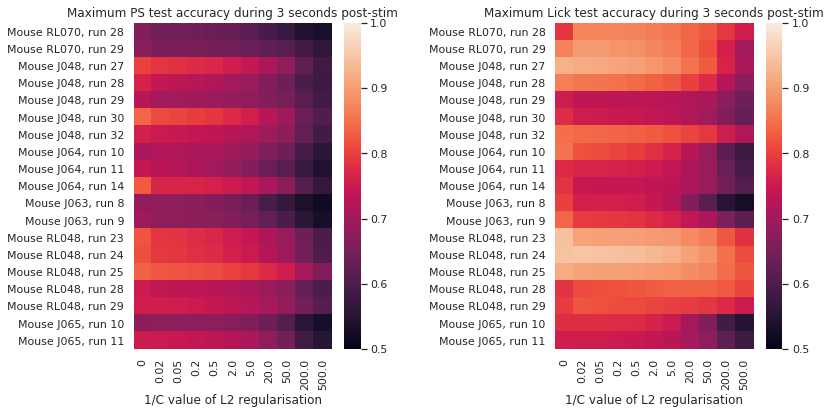

In [474]:
n_sessions = len(max_acc_scores)
n_cvalues = max_acc_scores[0].shape[0]
dict_max_acc_all = {xx: np.zeros((n_sessions, n_cvalues)) for xx in ['PS', 'Lick']}
for key, acc in max_acc_scores.items():
    dict_max_acc_all['Lick'][key, :] = acc[:, 0]
    dict_max_acc_all['PS'][key, :] = acc[:, 1]
    
c_labels = [0] + [1/c for c in c_value_array]
ss_labels = [str(ss) for key, ss in sessions.items()]
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(wspace=0.7)
for i_plot, xx in enumerate(['PS', 'Lick']):
    plt.subplot(1, 2, i_plot + 1)
    ax1 = sns.heatmap(dict_max_acc_all[xx], xticklabels=c_labels, yticklabels=ss_labels, vmin=0.5, vmax=1)
    plt.xlabel('1/C value of L2 regularisation'); plt.title(f'Maximum {xx} test accuracy during 3 seconds post-stim')
    bottom, top = ax1.get_ylim()
    ax1.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('figures/optimise_regularisation.pdf', bbox_inches='tight')

In [371]:
def create_df_table_details(sessions):
    """Create Dataframe table with details of sessions."""
    n_sessions = len(sessions)
    column_names = ['Mouse', 'Run number', 'Frequency (Hz)', '# Imaging planes',
                    '# S1 neurons', '# S2 neurons',
                    '# trials', '# Hit', '# FA', '# Miss', '# CR']
    dict_details = {cc: np.zeros(n_sessions, dtype='object') for cc in column_names}
    for key, ss in sessions.items():
        dict_details['Mouse'][key] = ss.mouse
        dict_details['Run number'][key] = ss.run_number
        dict_details['Frequency (Hz)'][key] = ss.frequency
        dict_details['# Imaging planes'][key] = len(np.unique(ss.plane_number))
        dict_details['# S1 neurons'][key] = np.sum(ss.s1_bool)
        dict_details['# S2 neurons'][key] = np.sum(ss.s2_bool)
        dict_details['# trials'][key] = len(ss.outcome)
        dict_details['# Hit'][key] = np.sum(ss.outcome == 'hit')
        dict_details['# FA'][key] = np.sum(ss.outcome == 'fp')
        dict_details['# Miss'][key] = np.sum(ss.outcome == 'miss')
        dict_details['# CR'][key] = np.sum(ss.outcome == 'cr')
    df_details = pd.DataFrame(dict_details)
    df_details = df_details.sort_values(by=['Mouse', 'Run number'])
    df_details = df_details.reset_index()
    del df_details['index']
    return df_details

df_details = create_df_table_details(sessions=sessions)
df_details
# df_details.to_latex(index=False)  # print latex Tabular code

,Mouse,Run number,Frequency (Hz),# Imaging planes,# S1 neurons,# S2 neurons,# trials,# Hit,# FA,# Miss,# CR
0,J048,27,5,3,1015,1086,130,59,25,21,25
1,J048,28,5,3,1060,1134,160,70,17,37,36
2,J048,29,5,3,758,772,303,131,41,73,58
3,J048,30,5,3,966,1119,209,97,30,34,48
4,J048,32,5,3,1005,967,254,98,24,68,64
5,J063,8,30,1,77,83,114,42,10,33,29
6,J063,9,30,1,320,439,210,97,19,51,43
7,J064,10,30,1,251,225,163,80,28,22,33
8,J064,11,30,1,439,363,167,92,13,31,31
9,J064,14,30,1,522,459,209,113,25,36,35


## ideas to improve / directions to go

#### Current plot:

- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)


#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- Use increasing/decreasing number of neurons